In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import zipfile
with zipfile.ZipFile('/content/drive/My Drive/Todo/dataset_all.zip') as z:
  z.extractall(".")
    

In [ ]:
import os
os.listdir('/content/dataset')

['words', 'words.txt', '.DS_Store']

In [ ]:
from __future__ import division
from __future__ import print_function
from itertools import groupby
import numpy as np


def ctcBestPath(mat, classes):
    "implements best path decoding as shown by Graves (Dissertation, p63)"

    # get char indices along best path
    best_path = np.argmax(mat, axis=1)
    #print('bp', best_path)
    # collapse best path (using itertools.groupby), map to chars, join char list to string
    blank_idx = 0
    best_chars_collapsed = [classes[k] for k, _ in groupby(best_path) if k != blank_idx]
    res = ''.join(best_chars_collapsed)
    return res

In [ ]:
import torch
import cv2 as cv
import numpy as np
#from CTCBestPath import ctcBestPath

class ImagePreprocess:
    def __init__(self):
        pass

    def resize_image(self, image, image_size):
        # transpose vertical Todo image
        #image = cv.transpose(image)


        # increase contrast
        pxmin = np.min(image)
        pxmax = np.max(image)
        imgContrast = (image - pxmin) / (pxmax - pxmin) * 255

        # create target image and copy sample image into it
        (wt, ht) = image_size
        #(h, w, _) = image.shape - for color image case
        (h, w) = image.shape
        fx = w / wt
        fy = h / ht
        f = max(fx, fy)
        newSize = (max(min(wt, int(w / f)), 1), max(min(ht, int(h / f)), 1)) # scale according to f (result at least 1 and at most wt or ht)
        image = cv.resize(imgContrast, newSize)
    
        target = np.ones([ht, wt]) * 255
        target[0:newSize[1], 0:newSize[0]] = image
        #target = np.ones([ht, wt, 3]) * 255
        #target[0:newSize[1], 0:newSize[0], :] = image
        image = cv.transpose(target)

      
        return image


class LabelConverter:
    def __init__(self, char_set, ignore_case=False):
        self.char_set = char_set
        if ignore_case:
            char_set = char_set.lower()
        
    def encode_text(self, text):
        "puts ground truth texts into tensor for ctc_loss and returns lenghts of labels"

        length = []
        result = []
        for item in text:            
            #item = item.decode('utf-8','strict')
            length.append(len(item))
            r = []
            for char in item:
                index = self.char_set.index(char)
                # result.append(index)
                r.append(index)
            result.append(r)
        
        max_len = 0
        for r in result:
            if len(r) > max_len:
                max_len = len(r)
        
        result_temp = []
        for r in result:
            for _ in range(max_len - len(r)):
                r.append(0)
            result_temp.append(r)

        text = result_temp
        return (torch.LongTensor(text), torch.LongTensor(length))

    def decode_text(self, encoded_text):
        "extract texts from output of CTC decoder"

        text = []
        #print("Encoded size:", encoded_text.shape)
        for encoded in encoded_text:
            text.append(ctcBestPath(encoded, self.char_set))
        return text




In [ ]:
from torch.utils.data import Dataset
import cv2 as cv
#from utils import LabelConverter, ImagePreprocess



class TodoDataset(Dataset):
    def __init__(self, file_path, image_size, transform=None):
        """ init dataset """
        self.image_size = image_size
        self.samples = []
        self.file_path = file_path
        self.char_set = ''
        self._init_dataset()
        self.preprocessor = ImagePreprocess()
        self.transform = transform
        

    def __len__(self):
        """ returns size of dataset """
        return len(self.samples)

    def __getitem__(self, idx):
        """ returns element by index """
        image = cv.imread(self.samples[idx][0], cv.IMREAD_GRAYSCALE)
        if self.transform is not None:
            image = self.transform(image)

        image = self.preprocessor.resize_image(np.float32(image), self.image_size)
        gt_text = self.samples[idx][1]
        return image, gt_text
    
    def _init_dataset(self):
        """ loads file paths and labels """
        chars = set()
        with open(self.file_path + "/words.txt", 'r') as input_file:
            for line in input_file:
                line_split = line.strip().split('\t')
                file_name = self.file_path+"/words/"+line_split[1]
                gt_text = line_split[0]
                chars = chars.union(set(list(gt_text)))
                self.samples.append((file_name, gt_text))
        input_file.close()

        self.char_set = sorted(list(chars))


    

In [ ]:
import torch

class LayersCNN(torch.nn.Module):
    """ CNN layers of net """
    def __init__(self, activation='relu', pooling='max'):
        super(LayersCNN, self).__init__()

        if activation == 'tanh':
            activation_function = torch.nn.Tanh()
        elif activation == 'relu':
            activation_function  = torch.nn.ReLU()
        else:
            raise NotImplementedError

        kernel_size = [5, 5, 3, 3, 3]
        features_num = [1, 32, 64, 128, 128, 256]
        pooling_ksize = pooling_stride = [(2,2), (2,2), (2,2), (2,1), (2,1)]

        self.rnn_input = features_num[-1]

        self.conv1 = torch.nn.Conv2d(in_channels=features_num[0], out_channels=features_num[1], kernel_size=kernel_size[0], padding=2)
        self.act1 = activation_function
        
        if pooling == 'avg':
            self.pool1 = torch.nn.AvgPool2d(kernel_size=pooling_ksize[0], stride=pooling_stride[0])
        elif pooling == 'max':
            self.pool1 = torch.nn.MaxPool2d(kernel_size=pooling_ksize[0], stride=pooling_stride[0])
        else:
            raise NotImplementedError
        
        self.conv2 = torch.nn.Conv2d(in_channels=features_num[1], out_channels=features_num[2], kernel_size=kernel_size[1], padding=2)
        self.act2 = activation_function

        if pooling == 'avg':
            self.pool2 = torch.nn.AvgPool2d(kernel_size=pooling_ksize[1], stride=pooling_stride[1])
        elif pooling == 'max':
            self.pool2 = torch.nn.MaxPool2d(kernel_size=pooling_ksize[1], stride=pooling_stride[1])
        else:
            raise NotImplementedError

        self.conv3 = torch.nn.Conv2d(in_channels=features_num[2], out_channels=features_num[3], kernel_size=kernel_size[2], padding=1)
        self.act3 = activation_function

        if pooling == 'avg':
            self.pool3 = torch.nn.AvgPool2d(kernel_size=pooling_ksize[2], stride=pooling_stride[2])
        elif pooling == 'max':
            self.pool3 = torch.nn.MaxPool2d(kernel_size=pooling_ksize[2], stride=pooling_stride[2])
        else:
            raise NotImplementedError

        self.conv4 = torch.nn.Conv2d(in_channels=features_num[3], out_channels=features_num[4], kernel_size=kernel_size[3], padding=1)
        self.act4 = activation_function

        if pooling == 'avg':
            self.pool4 = torch.nn.AvgPool2d(kernel_size=pooling_ksize[3], stride=pooling_stride[3])
        elif pooling == 'max':
            self.pool4 = torch.nn.MaxPool2d(kernel_size=pooling_ksize[3], stride=pooling_stride[3])
        else:
            raise NotImplementedError

        self.conv5 = torch.nn.Conv2d(in_channels=features_num[4], out_channels=features_num[5], kernel_size=kernel_size[4], padding=1)
        self.act5 = activation_function
        
        if pooling == 'avg':
            self.pool5 = torch.nn.AvgPool2d(kernel_size=pooling_ksize[4], stride=pooling_stride[4])
        elif pooling == 'max':
            self.pool5 = torch.nn.MaxPool2d(kernel_size=pooling_ksize[4], stride=pooling_stride[4])
        else:
            raise NotImplementedError
        
    def forward(self, x):
        x = x.unsqueeze(1)
        # input size: batch_size * channels * img_width * img_height. Example% 10x3x32x192
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        # output size: 10x32x16x96
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        # output size: 10x64x8x48
        x = self.conv3(x)
        x = self.act3(x)
        x = self.pool3(x)
        # output size: 10x128x4x24
        x = self.conv4(x)
        x = self.act4(x)
        x = self.pool4(x)
        # output size: 10x128x2x24
        x = self.conv5(x)
        x = self.act5(x)
        x = self.pool5(x)
        # output size: 10x256x1x24 -> 256 features and 24 timesteps
        return x

class LayersRNN(torch.nn.Module):
    """ RNN layers of net """
    def __init__(self, num_in, num_hidden, num_out):
        super(LayersRNN, self).__init__()

        self.rnn = torch.nn.LSTM(num_in, num_hidden, bidirectional=True)
        self.embedding = torch.nn.Linear(num_hidden * 2, num_out)

    def forward(self, input):
        recurrent, _ = self.rnn(input)
        T, b, h = recurrent.size() # size of LSTM output: [seq_len, batch, 2(bidirectional) * hidden_size]
        t_rec = recurrent.view(T * b, h) # resize for Linear embedding layer

        output = self.embedding(t_rec)  # size of Linear output: [T * b, num_out]
        output = output.view(T, b, -1)

        return output


class Model(torch.nn.Module):
    """ NN Model for Todo Bicig recognition """
    def __init__(self, rnn_hidden, num_char):
        super(Model, self).__init__()
        self.cnn = LayersCNN()
        self.rnn = torch.nn.Sequential(
            LayersRNN(self.cnn.rnn_input, rnn_hidden, rnn_hidden),
            LayersRNN(rnn_hidden, rnn_hidden, num_char))
        
    def forward(self, x):
        cnn_out = self.cnn(x) # cnn output size: 10x256x1x24 -> 256 features and 24 time-steps
        cnn_out = cnn_out.squeeze(2) #remove dimension with 1 width -> 10x256x24
        cnn_out = cnn_out.permute(2, 0, 1)  # change dimension to 24x10x256 (timesteps x batch_size x channels)
        rnn_out = self.rnn(cnn_out) # rnn output size: 24x10x41, where 40 is charset lenght + 1 blank
        
        # add log_softmax to converge output
        output = torch.nn.functional.log_softmax(rnn_out, dim=2) #size: 24x10x41
        
        return output

In [ ]:
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
import torch
#from TodoDataset import TodoDataset
#from utils import LabelConverter
#from Model import Model
from tqdm import tqdm
import editdistance
import random

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True

l_rate = 5.0e-4
steps = 10
n_epoch = 60
gamma = 0.5

def train_model(model, loss, optimizer, scheduler, num_epochs, train_dataloader, val_dataloader, converter):
    
    train_loss = []
    val_loss = []
    char_error = []
    word_acc = []

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.

            # character/word recognition params
            char_err = 0 
            char_total = 0 
            word_ok = 0 
            word_total = 0

            # Iterate over data.
            for inputs, texts in tqdm(dataloader):
                
                #inputs = inputs.permute(0, 3, 1, 2).float().to(device)
                inputs = inputs.float().to(device)
                #print(inputs.dtype)
                labels, lenghts = converter.encode_text(texts)
                labels = labels.to(device)
                #lenghts = lenghts.to(device)
                batch_size = inputs.size(0)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    preds_size = torch.LongTensor([preds.size(0)] * batch_size)
                    loss_value = loss(preds, labels, preds_size, lenghts) / batch_size 

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()
                    elif phase == 'val':
                        batch_char_err, batch_char_total, batch_word_ok, batch_word_total = check_accuracy(preds, texts, converter)
                        
                        char_err += batch_char_err
                        char_total += batch_char_total
                        word_ok += batch_word_ok
                        word_total += batch_word_total
                # statistics
                running_loss += loss_value.item()
                

            epoch_loss = running_loss / len(dataloader)
            
            print('{} Loss: {:.4f}'.format(phase, epoch_loss), flush=True)

            if phase == 'train':
                train_loss.append(epoch_loss) 
            else:
                val_loss.append(epoch_loss)

                char_error_rate = char_err / char_total
                word_accuracy = word_ok / word_total
                char_error.append(char_error_rate)
                word_acc.append(word_accuracy)
                print('Character error rate: %f%%. Word accuracy: %f%%.' % (char_error_rate*100.0, word_accuracy*100.0))

    return train_loss, val_loss, char_error, word_acc

def check_accuracy(preds, gt_texts, converter):

    num_char_err = 0
    num_char_total = 0
    num_word_ok = 0
    num_word_total = 0

    preds = preds.permute(1, 0, 2)
    #print("Preds: ", preds)
    recognized = converter.decode_text(preds.data.cpu().numpy())

    #print('Ground truth -> Recognized')    
    for i in range(len(recognized)):
        num_word_ok += 1 if gt_texts[i] == recognized[i] else 0
        num_word_total += 1
        dist = editdistance.eval(recognized[i], gt_texts[i])
        num_char_err += dist
        num_char_total += len(gt_texts[i])
        #print('[OK]' if dist==0 else '[ERR:%d]' % dist,'"' + gt_texts[i] + '"', '->', '"' + recognized[i] + '"')
    
    return num_char_err, num_char_total, num_word_ok, num_word_total
    


def test_model(loader):

    #char_error_rate = num_char_err / num_char_total
    #word_accuracy = num_word_ok / num_word_total
    #print('Character error rate: %f%%. Word accuracy: %f%%.' % (char_error_rate*100.0, word_accuracy*100.0))
    #return char_error_rate

    pass

def main():
    """ main function """
    
    data_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Grayscale(),
        transforms.RandomAffine((-5,5), fillcolor=255, translate=(0.25, 0), scale=(0.8, 1.2)),
        # transforms.Resize((192, 32)),
        #transforms.ToTensor()
    ])

    dataset = TodoDataset('dataset', (32, 192), transform=data_transform)

    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size

    train_loss = [] 
    val_loss = [] 
    char_error = [] 
    word_acc = []

    #val_size = len(dataset) - train_size

    train_set, val_set = random_split(dataset, [train_size, val_size])
    train_dataloader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=10)
    val_dataloader = DataLoader(val_set, batch_size=128, shuffle=True, num_workers=10)

    model = Model(1024, len(dataset.char_set) + 1)
    loss = torch.nn.CTCLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=l_rate, amsgrad=True)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=steps, gamma=gamma)

    converter = LabelConverter(dataset.char_set)

    train_loss, val_loss, char_error, word_acc = train_model(model=model, loss=loss, optimizer=optimizer, scheduler=scheduler, num_epochs=n_epoch, 
                train_dataloader=train_dataloader, val_dataloader=val_dataloader, converter=converter)

    torch.save(model.state_dict(), '/content/drive/My Drive/Todo/model_LR_{}_STEPS_{}_G_{}_EPOCHS_{}.pth'.format(l_rate, steps, gamma, n_epoch))
    #print(model)
    
    #for i, batch in enumerate(dataloader):
        #print(i, batch)
    #_, texts = next(iter(train_dataloader))
    #print(len(dataset.char_set))
    #print(texts)
    #converter = LabelConverter(dataset.char_set)
    #print(converter.encode_text(texts))
    return train_loss, val_loss, char_error, word_acc


In [ ]:
train_loss, val_loss, char_error, word_acc = main()

Epoch 0/59:


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
100%|██████████| 596/596 [02:08<00:00,  4.65it/s]

train Loss: 0.0270



100%|██████████| 149/149 [00:11<00:00, 12.88it/s]

val Loss: 0.0259
Character error rate: 94.415158%. Word accuracy: 0.000000%.
Epoch 1/59:



100%|██████████| 596/596 [02:21<00:00,  4.22it/s]

train Loss: 0.0185



100%|██████████| 149/149 [00:12<00:00, 11.64it/s]

val Loss: 0.1132
Character error rate: 119.522052%. Word accuracy: 0.000000%.
Epoch 2/59:



100%|██████████| 596/596 [02:25<00:00,  4.09it/s]

train Loss: 0.0107



100%|██████████| 149/149 [00:13<00:00, 11.37it/s]

val Loss: 0.0104
Character error rate: 42.074230%. Word accuracy: 20.168023%.
Epoch 3/59:



100%|██████████| 596/596 [02:26<00:00,  4.07it/s]

train Loss: 0.0037



100%|██████████| 149/149 [00:12<00:00, 11.80it/s]

val Loss: 0.0065
Character error rate: 26.426717%. Word accuracy: 43.686007%.
Epoch 4/59:



100%|██████████| 596/596 [02:26<00:00,  4.07it/s]

train Loss: 0.0023



100%|██████████| 149/149 [00:12<00:00, 11.73it/s]

val Loss: 0.0054
Character error rate: 22.343271%. Word accuracy: 47.119979%.
Epoch 5/59:



100%|██████████| 596/596 [02:26<00:00,  4.06it/s]

train Loss: 0.0019



100%|██████████| 149/149 [00:12<00:00, 11.74it/s]

val Loss: 0.0019
Character error rate: 7.582147%. Word accuracy: 79.107377%.
Epoch 6/59:



100%|██████████| 596/596 [02:26<00:00,  4.07it/s]

train Loss: 0.0013



100%|██████████| 149/149 [00:12<00:00, 11.61it/s]

val Loss: 0.0015
Character error rate: 6.261348%. Word accuracy: 81.832502%.
Epoch 7/59:



100%|██████████| 596/596 [02:26<00:00,  4.06it/s]

train Loss: 0.0011



100%|██████████| 149/149 [00:12<00:00, 11.76it/s]

val Loss: 0.0023
Character error rate: 8.855112%. Word accuracy: 73.462851%.
Epoch 8/59:



100%|██████████| 596/596 [02:26<00:00,  4.06it/s]

train Loss: 0.0011



100%|██████████| 149/149 [00:12<00:00, 11.66it/s]

val Loss: 0.0010
Character error rate: 3.944825%. Word accuracy: 87.645051%.
Epoch 9/59:



100%|██████████| 596/596 [02:26<00:00,  4.06it/s]

train Loss: 0.0007



100%|██████████| 149/149 [00:12<00:00, 11.64it/s]

val Loss: 0.0008
Character error rate: 3.186318%. Word accuracy: 89.850354%.
Epoch 10/59:



100%|██████████| 596/596 [02:26<00:00,  4.06it/s]

train Loss: 0.0006



100%|██████████| 149/149 [00:12<00:00, 11.63it/s]

val Loss: 0.0008
Character error rate: 3.269295%. Word accuracy: 89.866107%.
Epoch 11/59:



100%|██████████| 596/596 [02:26<00:00,  4.06it/s]

train Loss: 0.0006



100%|██████████| 149/149 [00:12<00:00, 11.55it/s]

val Loss: 0.0007
Character error rate: 2.945196%. Word accuracy: 90.580205%.
Epoch 12/59:



100%|██████████| 596/596 [02:26<00:00,  4.06it/s]

train Loss: 0.0005



100%|██████████| 149/149 [00:12<00:00, 11.54it/s]

val Loss: 0.0009
Character error rate: 3.667584%. Word accuracy: 88.621685%.
Epoch 13/59:



100%|██████████| 596/596 [02:26<00:00,  4.06it/s]

train Loss: 0.0005



100%|██████████| 149/149 [00:12<00:00, 11.61it/s]

val Loss: 0.0016
Character error rate: 6.463422%. Word accuracy: 80.162772%.
Epoch 14/59:



100%|██████████| 596/596 [02:26<00:00,  4.06it/s]

train Loss: 0.0007



100%|██████████| 149/149 [00:12<00:00, 11.61it/s]

val Loss: 0.0008
Character error rate: 3.221461%. Word accuracy: 90.055133%.
Epoch 15/59:



100%|██████████| 596/596 [02:26<00:00,  4.06it/s]

train Loss: 0.0005



100%|██████████| 149/149 [00:12<00:00, 11.68it/s]

val Loss: 0.0006
Character error rate: 2.489311%. Word accuracy: 91.940142%.
Epoch 16/59:



100%|██████████| 596/596 [02:26<00:00,  4.07it/s]

train Loss: 0.0004



100%|██████████| 149/149 [00:12<00:00, 11.52it/s]

val Loss: 0.0006
Character error rate: 2.290166%. Word accuracy: 92.627986%.
Epoch 17/59:



100%|██████████| 596/596 [02:27<00:00,  4.05it/s]

train Loss: 0.0004



100%|██████████| 149/149 [00:12<00:00, 11.61it/s]

val Loss: 0.0005
Character error rate: 2.267713%. Word accuracy: 92.748753%.
Epoch 18/59:



100%|██████████| 596/596 [02:26<00:00,  4.06it/s]

train Loss: 0.0003



100%|██████████| 149/149 [00:12<00:00, 11.68it/s]

val Loss: 0.0005
Character error rate: 2.173998%. Word accuracy: 92.843266%.
Epoch 19/59:



100%|██████████| 596/596 [02:26<00:00,  4.06it/s]

train Loss: 0.0003



100%|██████████| 149/149 [00:12<00:00, 11.67it/s]

val Loss: 0.0005
Character error rate: 1.954353%. Word accuracy: 93.651877%.
Epoch 20/59:



100%|██████████| 596/596 [02:27<00:00,  4.05it/s]

train Loss: 0.0003



100%|██████████| 149/149 [00:12<00:00, 11.60it/s]

val Loss: 0.0005
Character error rate: 2.004139%. Word accuracy: 93.657128%.
Epoch 21/59:



100%|██████████| 596/596 [02:27<00:00,  4.05it/s]

train Loss: 0.0002



100%|██████████| 149/149 [00:12<00:00, 11.62it/s]

val Loss: 0.0004
Character error rate: 1.838185%. Word accuracy: 94.029929%.
Epoch 22/59:



100%|██████████| 596/596 [02:26<00:00,  4.06it/s]

train Loss: 0.0002



100%|██████████| 149/149 [00:12<00:00, 11.64it/s]

val Loss: 0.0004
Character error rate: 1.802066%. Word accuracy: 93.966920%.
Epoch 23/59:



100%|██████████| 596/596 [02:27<00:00,  4.05it/s]

train Loss: 0.0002



100%|██████████| 149/149 [00:12<00:00, 11.61it/s]

val Loss: 0.0005
Character error rate: 1.857709%. Word accuracy: 94.087687%.
Epoch 24/59:



100%|██████████| 596/596 [02:26<00:00,  4.06it/s]

train Loss: 0.0002



100%|██████████| 149/149 [00:12<00:00, 11.66it/s]

val Loss: 0.0004
Character error rate: 1.817685%. Word accuracy: 93.982673%.
Epoch 25/59:



100%|██████████| 596/596 [02:26<00:00,  4.06it/s]

train Loss: 0.0002



100%|██████████| 149/149 [00:12<00:00, 11.68it/s]

val Loss: 0.0004
Character error rate: 1.785470%. Word accuracy: 94.182200%.
Epoch 26/59:



100%|██████████| 596/596 [02:26<00:00,  4.06it/s]

train Loss: 0.0002



100%|██████████| 149/149 [00:12<00:00, 11.57it/s]

val Loss: 0.0004
Character error rate: 1.681993%. Word accuracy: 94.518246%.
Epoch 27/59:



100%|██████████| 596/596 [02:26<00:00,  4.06it/s]

train Loss: 0.0002



100%|██████████| 149/149 [00:12<00:00, 11.73it/s]

val Loss: 0.0004
Character error rate: 1.694684%. Word accuracy: 94.323970%.
Epoch 28/59:



100%|██████████| 596/596 [02:27<00:00,  4.05it/s]

train Loss: 0.0002



100%|██████████| 149/149 [00:12<00:00, 11.58it/s]

val Loss: 0.0004
Character error rate: 1.767899%. Word accuracy: 94.145445%.
Epoch 29/59:



100%|██████████| 596/596 [02:27<00:00,  4.05it/s]

train Loss: 0.0002



100%|██████████| 149/149 [00:12<00:00, 11.57it/s]

val Loss: 0.0004
Character error rate: 1.624397%. Word accuracy: 94.576004%.
Epoch 30/59:



100%|██████████| 596/596 [02:27<00:00,  4.05it/s]

train Loss: 0.0002



100%|██████████| 149/149 [00:12<00:00, 11.62it/s]

val Loss: 0.0004
Character error rate: 1.521896%. Word accuracy: 94.880546%.
Epoch 31/59:



100%|██████████| 596/596 [02:26<00:00,  4.06it/s]

train Loss: 0.0002



100%|██████████| 149/149 [00:12<00:00, 11.67it/s]

val Loss: 0.0004
Character error rate: 1.674183%. Word accuracy: 94.565503%.
Epoch 32/59:



100%|██████████| 596/596 [02:26<00:00,  4.06it/s]

train Loss: 0.0002



100%|██████████| 149/149 [00:12<00:00, 11.63it/s]

val Loss: 0.0004
Character error rate: 1.556063%. Word accuracy: 94.833290%.
Epoch 33/59:



100%|██████████| 596/596 [02:26<00:00,  4.07it/s]

train Loss: 0.0001



100%|██████████| 149/149 [00:12<00:00, 11.68it/s]

val Loss: 0.0004
Character error rate: 1.535563%. Word accuracy: 94.870045%.
Epoch 34/59:



100%|██████████| 596/596 [02:26<00:00,  4.06it/s]

train Loss: 0.0001



100%|██████████| 149/149 [00:12<00:00, 11.66it/s]

val Loss: 0.0004
Character error rate: 1.538492%. Word accuracy: 94.891048%.
Epoch 35/59:



100%|██████████| 596/596 [02:26<00:00,  4.06it/s]

train Loss: 0.0002



100%|██████████| 149/149 [00:12<00:00, 11.65it/s]

val Loss: 0.0004
Character error rate: 1.570706%. Word accuracy: 95.006563%.
Epoch 36/59:



100%|██████████| 596/596 [02:26<00:00,  4.07it/s]

train Loss: 0.0001



100%|██████████| 149/149 [00:12<00:00, 11.61it/s]

val Loss: 0.0004
Character error rate: 1.614635%. Word accuracy: 94.717774%.
Epoch 37/59:



100%|██████████| 596/596 [02:26<00:00,  4.05it/s]

train Loss: 0.0001



100%|██████████| 149/149 [00:12<00:00, 11.66it/s]

val Loss: 0.0004
Character error rate: 1.516039%. Word accuracy: 94.896298%.
Epoch 38/59:



100%|██████████| 596/596 [02:27<00:00,  4.05it/s]

train Loss: 0.0001



100%|██████████| 149/149 [00:12<00:00, 11.70it/s]

val Loss: 0.0004
Character error rate: 1.540444%. Word accuracy: 94.875295%.
Epoch 39/59:



100%|██████████| 596/596 [02:26<00:00,  4.07it/s]

train Loss: 0.0001



100%|██████████| 149/149 [00:12<00:00, 11.74it/s]

val Loss: 0.0004
Character error rate: 1.528730%. Word accuracy: 94.975059%.
Epoch 40/59:



100%|██████████| 596/596 [02:26<00:00,  4.06it/s]

train Loss: 0.0001



100%|██████████| 149/149 [00:12<00:00, 11.69it/s]

val Loss: 0.0003
Character error rate: 1.426229%. Word accuracy: 95.232344%.
Epoch 41/59:



100%|██████████| 596/596 [02:27<00:00,  4.05it/s]

train Loss: 0.0001



100%|██████████| 149/149 [00:12<00:00, 11.62it/s]

val Loss: 0.0004
Character error rate: 1.524825%. Word accuracy: 95.116829%.
Epoch 42/59:



100%|██████████| 596/596 [02:26<00:00,  4.05it/s]

train Loss: 0.0001



100%|██████████| 149/149 [00:12<00:00, 11.49it/s]

val Loss: 0.0004


Character error rate: 1.496515%. Word accuracy: 95.216592%.
Epoch 43/59:


100%|██████████| 596/596 [02:27<00:00,  4.05it/s]

train Loss: 0.0001



100%|██████████| 149/149 [00:12<00:00, 11.54it/s]

val Loss: 0.0004
Character error rate: 1.531658%. Word accuracy: 95.048569%.
Epoch 44/59:



100%|██████████| 596/596 [02:26<00:00,  4.06it/s]

train Loss: 0.0001



100%|██████████| 149/149 [00:12<00:00, 11.50it/s]

val Loss: 0.0004
Character error rate: 1.475039%. Word accuracy: 95.169336%.
Epoch 45/59:



100%|██████████| 596/596 [02:27<00:00,  4.04it/s]

train Loss: 0.0001



100%|██████████| 149/149 [00:12<00:00, 11.65it/s]

val Loss: 0.0004
Character error rate: 1.493586%. Word accuracy: 94.948805%.
Epoch 46/59:



100%|██████████| 596/596 [02:26<00:00,  4.06it/s]

train Loss: 0.0001



100%|██████████| 149/149 [00:12<00:00, 11.69it/s]

val Loss: 0.0004
Character error rate: 1.497491%. Word accuracy: 95.132581%.
Epoch 47/59:



100%|██████████| 596/596 [02:26<00:00,  4.06it/s]

train Loss: 0.0001



100%|██████████| 149/149 [00:12<00:00, 11.67it/s]

val Loss: 0.0004
Character error rate: 1.476991%. Word accuracy: 95.074823%.
Epoch 48/59:



100%|██████████| 596/596 [02:26<00:00,  4.06it/s]

train Loss: 0.0001



100%|██████████| 149/149 [00:12<00:00, 11.63it/s]

val Loss: 0.0004
Character error rate: 1.461372%. Word accuracy: 95.174587%.
Epoch 49/59:



100%|██████████| 596/596 [02:27<00:00,  4.05it/s]

train Loss: 0.0001



100%|██████████| 149/149 [00:12<00:00, 11.52it/s]

val Loss: 0.0004
Character error rate: 1.537515%. Word accuracy: 94.948805%.
Epoch 50/59:



100%|██████████| 596/596 [02:26<00:00,  4.07it/s]

train Loss: 0.0001



100%|██████████| 149/149 [00:12<00:00, 11.67it/s]

val Loss: 0.0003
Character error rate: 1.451610%. Word accuracy: 95.143082%.
Epoch 51/59:



100%|██████████| 596/596 [02:26<00:00,  4.06it/s]

train Loss: 0.0001



100%|██████████| 149/149 [00:12<00:00, 11.69it/s]

val Loss: 0.0003
Character error rate: 1.420371%. Word accuracy: 95.169336%.
Epoch 52/59:



100%|██████████| 596/596 [02:26<00:00,  4.05it/s]

train Loss: 0.0001



100%|██████████| 149/149 [00:12<00:00, 11.67it/s]

val Loss: 0.0003
Character error rate: 1.422324%. Word accuracy: 95.227094%.
Epoch 53/59:



100%|██████████| 596/596 [02:26<00:00,  4.06it/s]

train Loss: 0.0001



100%|██████████| 149/149 [00:12<00:00, 11.64it/s]

val Loss: 0.0004
Character error rate: 1.458443%. Word accuracy: 95.290102%.
Epoch 54/59:



100%|██████████| 596/596 [02:26<00:00,  4.06it/s]

train Loss: 0.0001



100%|██████████| 149/149 [00:12<00:00, 11.70it/s]

val Loss: 0.0004
Character error rate: 1.463324%. Word accuracy: 95.169336%.
Epoch 55/59:



100%|██████████| 596/596 [02:27<00:00,  4.05it/s]

train Loss: 0.0001



100%|██████████| 149/149 [00:12<00:00, 11.70it/s]

val Loss: 0.0003
Character error rate: 1.405728%. Word accuracy: 95.274350%.
Epoch 56/59:



100%|██████████| 596/596 [02:26<00:00,  4.06it/s]

train Loss: 0.0001



100%|██████████| 149/149 [00:12<00:00, 11.72it/s]

val Loss: 0.0003
Character error rate: 1.417443%. Word accuracy: 95.353111%.
Epoch 57/59:



100%|██████████| 596/596 [02:26<00:00,  4.06it/s]

train Loss: 0.0001



100%|██████████| 149/149 [00:12<00:00, 11.70it/s]

val Loss: 0.0003
Character error rate: 1.393038%. Word accuracy: 95.300604%.
Epoch 58/59:



100%|██████████| 596/596 [02:26<00:00,  4.06it/s]

train Loss: 0.0001



100%|██████████| 149/149 [00:12<00:00, 11.64it/s]

val Loss: 0.0004
Character error rate: 1.467229%. Word accuracy: 95.095826%.
Epoch 59/59:



100%|██████████| 596/596 [02:26<00:00,  4.06it/s]

train Loss: 0.0001



100%|██████████| 149/149 [00:12<00:00, 11.65it/s]

val Loss: 0.0003


Character error rate: 1.433062%. Word accuracy: 95.253347%.


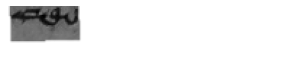

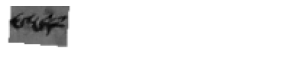

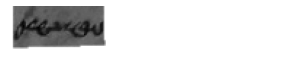

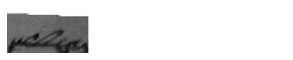

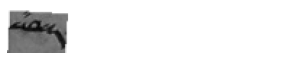

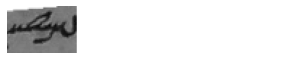

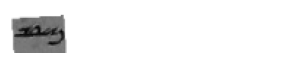

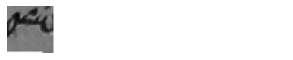

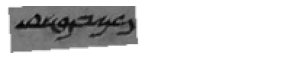

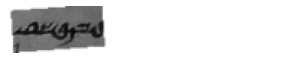

In [ ]:
from matplotlib import pyplot as plt
import os
%matplotlib inline

# Show image using matplotlib  
def show_image(img, size, colormap=0):
    plt.figure(figsize=size)
    plt.axis('off')
    if colormap:
        plt.imshow(img, cmap=colormap)
    else:
        plt.imshow(img)
    plt.show()


def test_transforms():

    data_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Grayscale(),
        transforms.RandomAffine((-5,5), fillcolor=255, translate=(0.25, 0), scale=(0.8, 1.2)),
        # transforms.Resize((192, 32)),
        #transforms.ToTensor()
    ])
    

    transformed_dataset = TodoDataset('dataset', (32, 192), transform=data_transform)

    for i in range(10):
        sample = transformed_dataset[i]
        show_image(sample[0], (5, 5), colormap='gray')

test_transforms()

In [ ]:
print(min(char_error), np.argmin(np.array(char_error)))

0.011109158710634726 41


Text(0.5, 1.0, 'word accuracy')

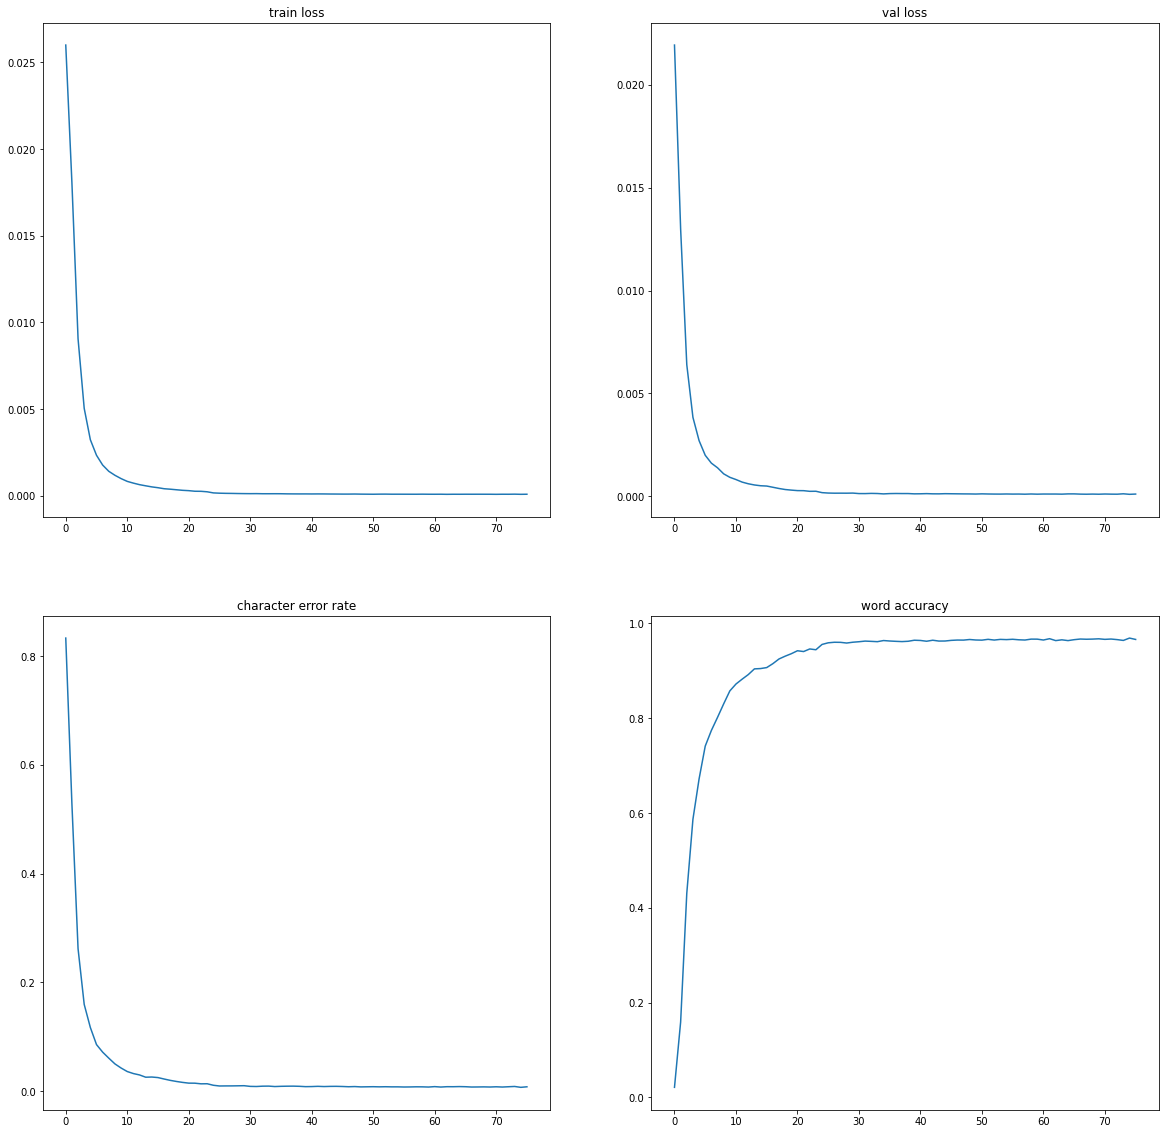

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(20,20))
axs[0][0].plot(train_loss)
axs[0][0].set_title('train loss')
axs[0][1].plot(val_loss)
axs[0][1].set_title('val loss')
axs[1][0].plot(char_error)
axs[1][0].set_title('character error rate')
axs[1][1].plot(word_acc)
axs[1][1].set_title('word accuracy')